# Creates plots from the eval runs over the checkpoints.

`2024-12-31_21-52-49_rlvr_gsm8k_only_smollm2_instruct` is the only real GSM8K only run.
https://wandb.ai/julesgm/open_instruct_rl/runs/jtobyw4t/overview is the associated Wandb run.

`2024-12-31_22-56-50_rlvr_gsm8k_only_smollm2_instruct` is the only real MATH only run.

In [3]:
# Standard library imports
import collections
import json
import os
import pathlib
import re

# Third party imports
import matplotlib.pyplot as plt
import more_itertools as mit
import numpy as np
import pandas as pd
import rich
import sklearn.linear_model as skl_lin


def extract_step(path):
    """ Look at the path name and extract the step number.
    
    Big assumption: Just takes the last number in the path name.
    """
    return int(re.findall(r"\d+", path.parent.name)[-1])


def extract_info_file(*, file, task_key, is_baseline=False):
    """ Reads the lighteval JSON file and extract the performance.
    """ 

    file = pathlib.Path(file)

    if is_baseline:
        step = 0
    else:
        step = extract_step(file)

    d = json.loads(file.read_text())
    task_results = d["results"][task_key]
    qem = task_results["qem"]
    qem_stderr = task_results["qem_stderr"]

    return dict(step=step, qem=qem, qem_stderr=qem_stderr)


def plot_task(*, baseline_file, files, task_key, legend, marker="o", linestyle="-"):
    """ Extracts the performance from the files
    """

    files = sorted(files, key=extract_step)
    
    shared = files[0].parent.parts
    for file_ in files:
        parts = file_.parent.parts
        for i, shared_part in enumerate(shared):
            if shared_part != parts[i]:
                shared = shared[:i]
                break
        if len(shared) == 0:
            break
    merged_shared = pathlib.Path(*shared)
    # rich.print(f"[bold]Shared path: {merged_shared}")
    # for file_ in files:
    #     print(file_.relative_to(merged_shared))
    
    if baseline_file:
        results = [
            extract_info_file(
                file=baseline_file,
                task_key=task_key,
                is_baseline=True,
            )]
    else:
        results = []

    for file in files:
        results.append(
            extract_info_file(
                file=file,
                task_key=task_key,
            )
        )

    results = pd.DataFrame(results)
    x = results["step"]
    y = results["qem"]    
    plt.plot(x, y, label=legend, marker=marker, linestyle=linestyle)
    # Get the color of the last plot
    color = plt.gca().lines[-1].get_color()
    
    # # Smooth with a linear regression
    # model = skl_lin.LinearRegression(fit_intercept=False)
    # model.fit(x.values.reshape(-1, 1), y - y[0])
    # x_pred = pd.Series(range(0, x.max() + 1))
    # y_pred = model.predict(x_pred.values.reshape(-1, 1)) + y[0]
    # plt.plot(x_pred, y_pred, linestyle="--", color=color)


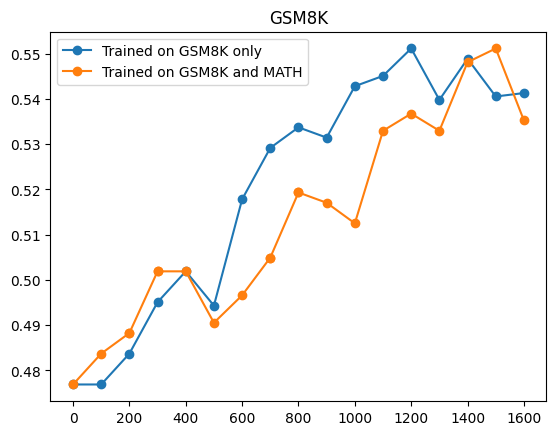

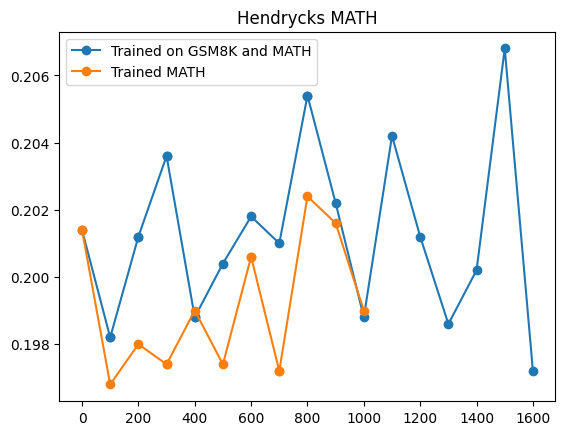

In [4]:
# Code to make plots for specific tasks.

MATH_BASELINE = "./all_eval_outputs_important/previous_outputs/outputs_math/results/HuggingFaceTB/SmolLM2-1.7B-Instruct/results_2025-01-02T20-51-13.105551.json"
GSM8K_BASELINE = "./all_eval_outputs_important/previous_outputs/outputs_gsm8k/results/HuggingFaceTB/SmolLM2-1.7B-Instruct/results_2025-01-02T15-48-12.453113.json"

def gsm8k():
    task_key = "custom|gsm8k|8"
    eval_output_root_path = pathlib.Path("./all_eval_outputs_important/previous_outputs/outputs_gsm8k/results/")
    plt.figure()
    plt.title("GSM8K")
    gsm8k_baseline_file = eval_output_root_path / "HuggingFaceTB/SmolLM2-1.7B-Instruct/results_2025-01-02T15-48-12.453113.json"

    # GSM8K only
    glob_pattern = "_network_scratch_g_gagnonju_open_instruct_output_2024-12-31_21-52-49_rlvr_gsm8k_only_smollm2_instruct_checkpoints_step_*/*.json"
    files = eval_output_root_path.glob(glob_pattern)
    plot_task(baseline_file=gsm8k_baseline_file, files=files, task_key=task_key, legend="Trained on GSM8K only")
    print()
    
    # GSM8K and MATH
    glob_pattern = "_network_scratch_g_gagnonju_open_instruct_output_2024-12-31_21-22-51_rlvr_gsm8k_only_smollm2_instruct_checkpoints_step_*/*.json"
    files = eval_output_root_path.glob(glob_pattern)
    plot_task(baseline_file=gsm8k_baseline_file, files=files, task_key=task_key, legend="Trained on GSM8K and MATH")

    plt.legend()


def math():
    task_key = "custom|math|5"
    eval_output_root_path = pathlib.Path("./all_eval_outputs_important/previous_outputs/outputs_math/results/")

    plt.figure()
    plt.title("Hendrycks MATH")
    
    # Baseline
    math_baseline_file = eval_output_root_path / "HuggingFaceTB/SmolLM2-1.7B-Instruct/results_2025-01-02T20-51-13.105551.json"

    # GSM8K and MATH
    glob_pattern = "_network_scratch_g_gagnonju_open_instruct_output_2024-12-31_21-22-51_rlvr_gsm8k_only_smollm2_instruct_checkpoints_step_*/*.json"
    files = eval_output_root_path.glob(glob_pattern)
    plot_task(
        baseline_file=math_baseline_file, 
        files=files, 
        task_key=task_key, 
        legend="Trained on GSM8K and MATH"
    )

    glob_pattern = "_network_scratch_g_gagnonju_open_instruct_output_2024-12-31_22-56-50_rlvr_gsm8k_only_smollm2_instruct_checkpoints_step_*/*.json"
    files = eval_output_root_path.glob(glob_pattern)
    plot_task(
        baseline_file=math_baseline_file, 
        files=files, 
        task_key=task_key, 
        legend="Trained MATH",
    )

    plt.legend()


gsm8k()
math()

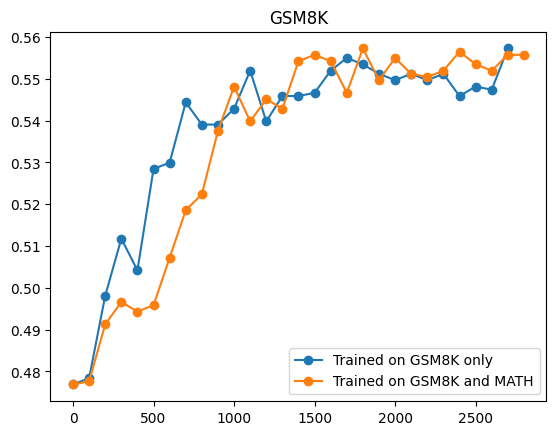

In [5]:
def gsm8k_lambdal():
    task_key = "custom|gsm8k|8"
    eval_output_root_path = pathlib.Path("./all_eval_outputs_important/lambdal_outputs_gsm8k/results/")
    
    plt.figure()
    plt.title("GSM8K")

    gsm8k_baseline_file = GSM8K_BASELINE

    # GSM8K only
    glob_pattern = "_network_scratch_g_gagnonju_lambdal_marglicot_openinstruct_open_instruct_output_2025-02-10_19-32-40_rlvr_gsm8k_only_smollm2_instruct_checkpoints_step_*/*.json"
    files = eval_output_root_path.glob(glob_pattern)
    assert files, "GSM8K Only: No files found"
    plot_task(baseline_file=gsm8k_baseline_file, files=files, task_key=task_key, legend="Trained on GSM8K only")
    print()
    
    eval_output_root_path = pathlib.Path("./all_eval_outputs_important/lambdal_outputs_task_gsm8k_train_gsm8k_math/results")

    # GSM8K and MATH
    glob_pattern = "_network_scratch_g_gagnonju_lambdal_marglicot_openinstruct_open_instruct_output_2025-02-10_19-35-25_rlvr_gsm8k_math_smollm2_instruct_checkpoints_step_*/*.json"
    files = eval_output_root_path.glob(glob_pattern)
    assert files, "GSM8K & MATH: No files found"
    plot_task(baseline_file=gsm8k_baseline_file, files=files, task_key=task_key, legend="Trained on GSM8K and MATH")

    plt.legend()
gsm8k_lambdal()

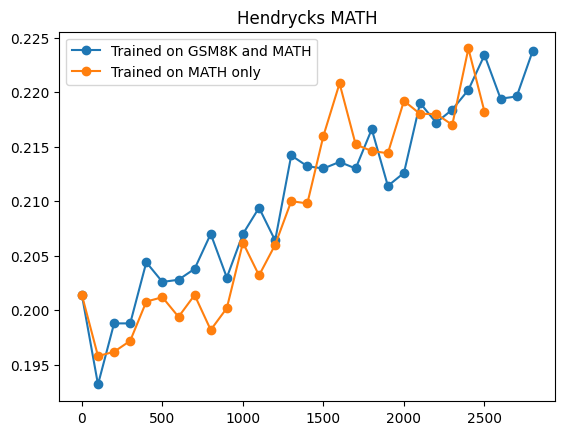

In [6]:
def from_path_and_glob(*, path, glob_pattern, baseline_file, task_key, setting_name):
    assert path.exists(), path
    
    path_glob_pattern = pathlib.Path(glob_pattern)
    assert len(pathlib.Path(glob_pattern).parts) == 2
    
    files = sorted(path.glob(glob_pattern))
    assert files, f"{setting_name}: No files found"

    plot_task(
        baseline_file=baseline_file, 
        files=files,
        task_key=task_key, 
        legend=f"Trained on {setting_name}"
    )

def math_lambdal():
    task_key = "custom|math|5"

    plt.figure()
    plt.title("Hendrycks MATH")
    
    # Baseline
    math_baseline_file = pathlib.Path(MATH_BASELINE)
    assert math_baseline_file.exists(), "Baseline file not found"

    # GSM8K and MATH
    task_math_train_gsm8k_math_path = pathlib.Path("./all_eval_outputs_important/lambdal_outputs_task_math_train_gsm8k_math/results/")
    glob_pattern = "_network_scratch_g_gagnonju_lambdal_marglicot_openinstruct_open_instruct_output_2025-02-10_19-35-25_rlvr_gsm8k_math_smollm2_instruct_checkpoints_step_*/*.json"
    from_path_and_glob(
        path=task_math_train_gsm8k_math_path,
        glob_pattern=glob_pattern,
        baseline_file=math_baseline_file,
        task_key=task_key,
        setting_name="GSM8K and MATH"
    )

    # MATH
    task_math_train_math = pathlib.Path("./all_eval_outputs_important/lambdal_outputs_math/results/")
    glob_pattern = "_network_scratch_g_gagnonju_lambdal_marglicot_openinstruct_open_instruct_output_2025-02-10_19-33-46_rlvr_math_only_smollm2_instruct_checkpoints_step_*/*.json"
    from_path_and_glob(
        path=task_math_train_math,
        glob_pattern=glob_pattern,
        baseline_file=math_baseline_file,
        task_key=task_key,
        setting_name="MATH only"
    )

    plt.legend()

math_lambdal()


n_shots: 0


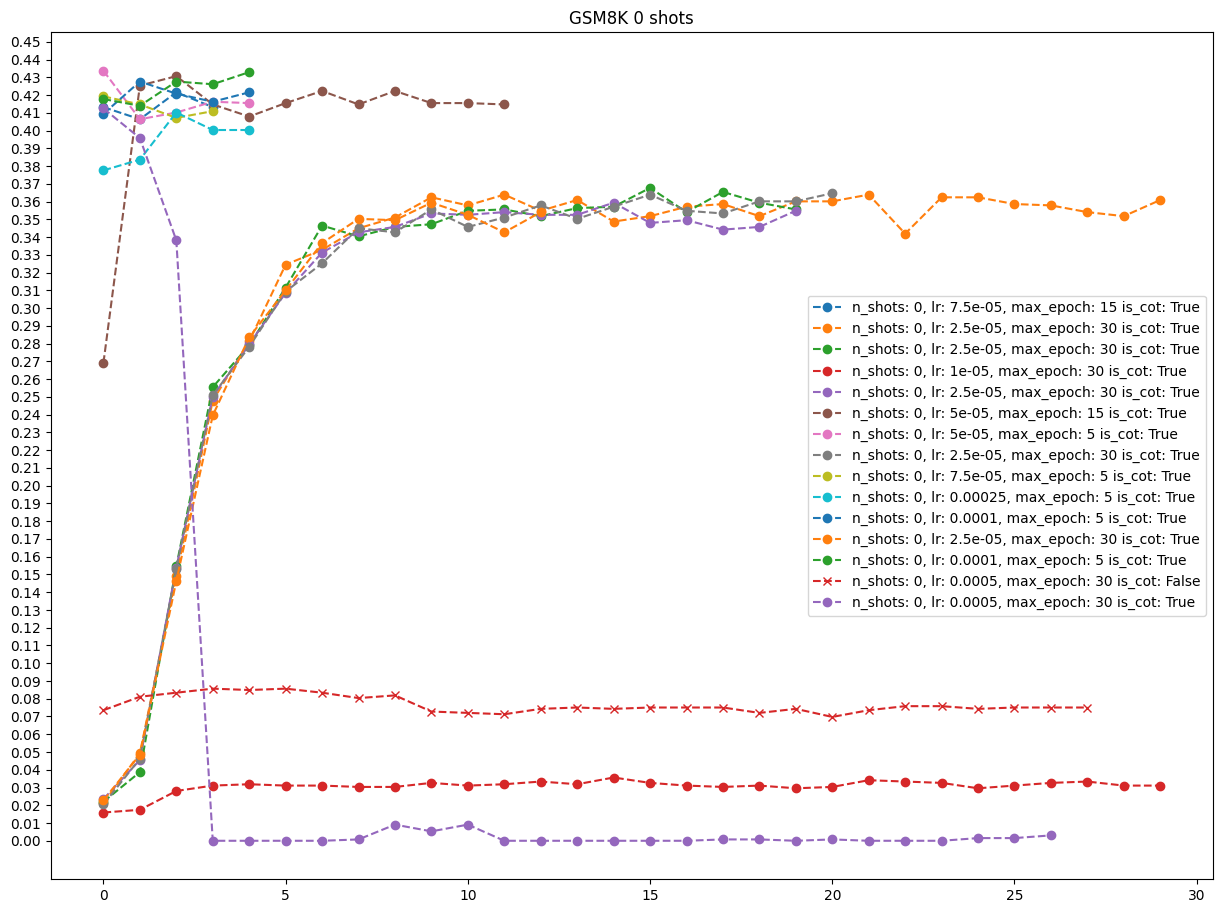

n_shots: 1
n_shots: 2
n_shots: 3
n_shots: 4
n_shots: 5
n_shots: 6
n_shots: 7
n_shots: 8


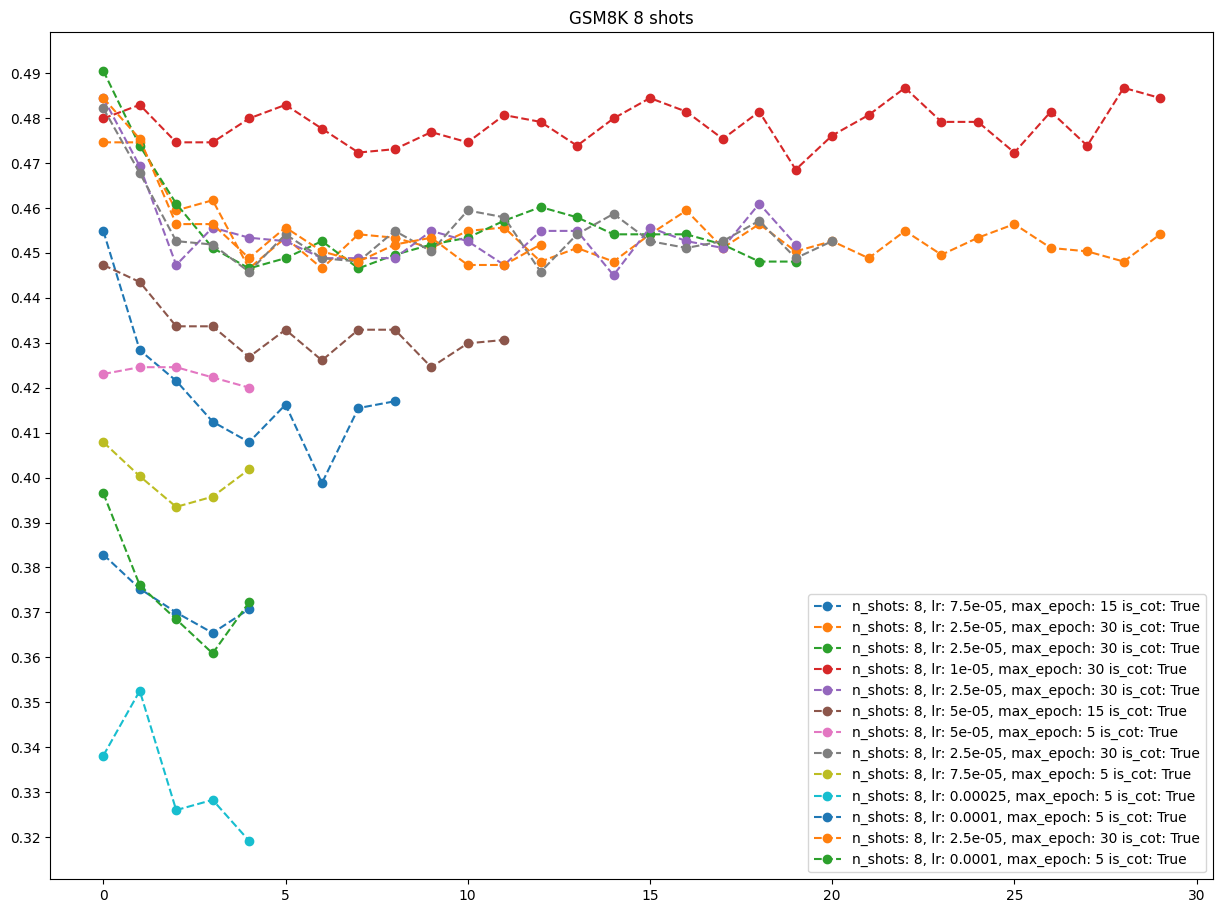

n_shots: 9
n_shots: 0


FileNotFoundError: [Errno 2] No such file or directory: 'all_eval_outputs_important/sft_outputs_math/0_shot/results'

In [53]:

def sft_outputs(n_shots: int, task):
    assert isinstance(n_shots, int), type(n_shots).mro()
    task_key = f"custom|{task}|{n_shots}"
    eval_output_root_path = pathlib.Path(f"./all_eval_outputs_important/sft_outputs_{task}/")

    if task == "gsm8k":
        other_task = "math"
    elif task == "math":
        other_task = "gsm8k"
    else:
        raise ValueError(f"Invalid task: {task}")

    runs = []
    for path in list(eval_output_root_path.iterdir()):
    
        shared = collections.defaultdict(list)
        for file in (path / "results").iterdir():
            if task in file.name.lower() and not other_task in file.name.lower():
                shared_file_name = file.name.rsplit("_", 2)[0]
                shared[shared_file_name].append(file)
            
        for shared_file_name, files in shared.items():
            runs.append((path / "results" / shared_file_name, files))


    initialized_figure = False

    for path, run in runs:
        learning_rates = set()
        max_epochs = set()
        is_cot = set()

        for indiv in run:
            meta_infos = list(indiv.glob("meta_info.json"))
            if not meta_infos:
                final = indiv.name.rsplit("sft_saves_", 1)[-1].rsplit("_model", 1)[0].rsplit("_", 1)[0]
                epoch = indiv.name.rsplit("_", 2)[-2]
                
                path = pathlib.Path(os.environ["SCRATCH"]) / "marglicot_saves" / "sft_saves" / indiv.parts[2] / "checkpoints" / final / str(epoch) / "meta_info.json"
                assert path.exists(), path
                meta_infos.append(path)
        
            meta_infos = mit.one(meta_infos)
            meta_info = json.loads(meta_infos.read_text().strip())
            learning_rates.add(meta_info["cfg"]["learning_rate"])
            max_epochs.add(meta_info["cfg"]["max_num_epochs"])
            is_cot.add(meta_info["cfg"]["output_type"]["enum"] == "chain_of_thought_then_answer")

        if len(is_cot) == 1:
            is_cot = mit.one(is_cot)
        else:
            is_cot = "unknown"

        if len(learning_rates) == 1:
            learning_rate = mit.one(learning_rates)
        else:
            learning_rate = "unknown"

        if len(max_epochs) == 1:
            max_epoch = mit.one(max_epochs)
        else:
            max_epoch = "unknown"
       

        n_shots_set = set()
        files = []
        for path in run:
            result = mit.first(path.glob("results*.json"), None)
            if result is not None:
                result_json = json.loads(result.read_text())
                task_keys = set(result_json["summary_tasks"].keys())
                task_key = mit.one(task_keys)
                config_n_shots = int(task_key.rsplit("|", 1)[-1])
                n_shots_set.add(config_n_shots)
                if config_n_shots == n_shots:
                    files.append(result)

        if not n_shots_set:
            n_shots_config = "unknown"
        else:
            n_shots_config = mit.one(n_shots_set, ValueError("Multiple n_shots found"))

        # print(f"n_shots: {n_shots_config}, lr: {learning_rate}, max_epoch: {max_epoch}")
        
        if files:
            if not initialized_figure:                
                plt.figure(figsize=(15, 11))
                plt.title(f"{task.upper()} {n_shots} shots")  
                plt.yticks(np.arange(0, 0.51, 0.01))
                initialized_figure = True

            plot_task(
                baseline_file=None,
                files=files,
                task_key=task_key,
                legend=f"n_shots: {n_shots}, lr: {learning_rate}, max_epoch: {max_epoch} is_cot: {is_cot}",
                marker="o" if is_cot else "x",
                linestyle="-" if n_shots == "0" else "--",
            )
        else:
            pass
            # rich.print(f"[bold]Skipped:[/bold] lr: {learning_rate} max_epoch: {max_epoch} is_cot: {is_cot}")
    
    if initialized_figure:
        plt.legend()
        plt.show()

for n_shots in range(0, 10):
    print(f"n_shots: {n_shots}")
    sft_outputs(n_shots, "gsm8k")

for n_shots in range(0, 10):
    print(f"n_shots: {n_shots}")
    sft_outputs(n_shots, "math")

Epoch 2
{'config_general': {'lighteval_sha': '?', 'num_fewshot_seeds': 1, 'override_batch_size': -1, 'max_samples': None, 'job_id': '', 'start_time': 14296438.947322655, 'end_time': 14296512.580050832, 'total_evaluation_time_secondes': '73.63272817619145', 'model_name': '_network_scratch_g_gagnonju_rejection_sampling_saves_gsm8k_2025-03-16_02-32-57_epoch_2', 'model_sha': '', 'model_dtype': None, 'model_size': None}, 'results': {'custom|gsm8k|0': {'qem': 0.006065200909780136, 'qem_stderr': 0.002138670301460471}, 'all': {'qem': 0.006065200909780136, 'qem_stderr': 0.002138670301460471}}, 'versions': {'custom|gsm8k|0': 0}, 'config_tasks': {'custom|gsm8k': {'name': 'gsm8k', 'prompt_function': 'jules_gsm8k', 'hf_repo': 'openai/gsm8k', 'hf_subset': 'main', 'metric': [{'metric_name': 'qem', 'higher_is_better': True, 'category': '3', 'use_case': '5', 'sample_level_fn': 'compute', 'corpus_level_fn': 'mean'}], 'hf_revision': 'e53f048856ff4f594e959d75785d2c2d37b678ee', 'hf_filter': None, 'hf_avail

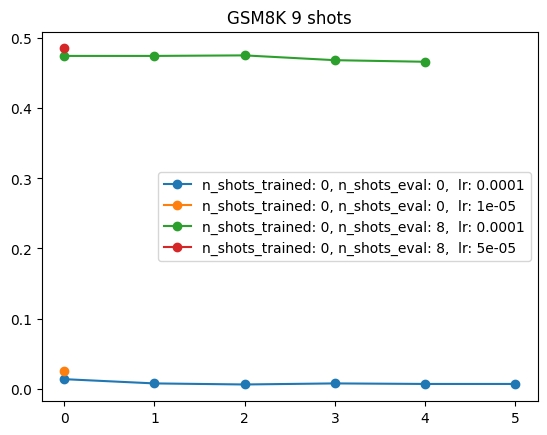

Epoch 0
{'config_general': {'lighteval_sha': '?', 'num_fewshot_seeds': 1, 'override_batch_size': -1, 'max_samples': None, 'job_id': '', 'start_time': 14296459.009183617, 'end_time': 14296572.86289152, 'total_evaluation_time_secondes': '113.85370790213346', 'model_name': '_network_scratch_g_gagnonju_rejection_sampling_saves_hendrycks_math_2025-03-16_19-48-52_epoch_0', 'model_sha': '', 'model_dtype': None, 'model_size': None}, 'results': {'custom|math|0': {'qem': 0.0292, 'qem_stderr': 0.0023813034500509713}, 'all': {'qem': 0.0292, 'qem_stderr': 0.0023813034500509713}}, 'versions': {'custom|math|0': 0}, 'config_tasks': {'custom|math': {'name': 'math', 'prompt_function': 'prompt_math', 'hf_repo': 'HuggingFaceTB/math_tasks', 'hf_subset': 'math', 'metric': [{'metric_name': 'qem', 'higher_is_better': True, 'category': '3', 'use_case': '5', 'sample_level_fn': 'compute', 'corpus_level_fn': 'mean'}], 'hf_revision': '3d34f1076f279000b9315583dcdacfd288898283', 'hf_filter': None, 'hf_avail_splits':

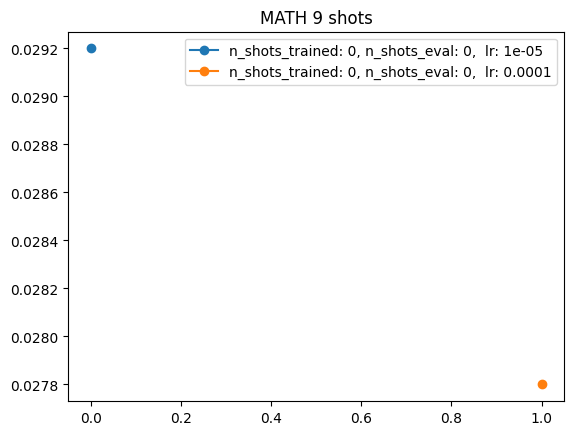

In [52]:
import dataclasses
import itertools

@dataclasses.dataclass(order=True, frozen=True, slots=True)
class EpochFile:
    epoch_number: int
    path: pathlib.Path = dataclasses.field(compare=False)

def supervised_sampling_outputs(n_shots_trained: int, n_shots_eval: int, task: str):
    assert isinstance(n_shots_trained, int), type(n_shots_trained).mro()
    assert isinstance(n_shots_eval, int), type(n_shots_eval).mro()

    task_key = f"custom|{task}|{n_shots_eval}"
    eval_output_root_path = pathlib.Path(f"./all_eval_outputs_important/rejection_sampling_outputs_{task}_trained_{n_shots_trained}_shot/{n_shots_eval}_shot")
    if not eval_output_root_path.exists():
        return
    
    epoch_folders = eval_output_root_path / "results"

    shared_start_files = collections.defaultdict(list)
    shared_start_learning_rates = collections.defaultdict(set)
    shared_start_epochs = collections.defaultdict(list)
    for epoch_folder in epoch_folders.iterdir():
        json_results = mit.first(epoch_folder.glob("results*.json"), None)
        if json_results is None:
            continue
        results_json = json.loads(json_results.read_text())
        hydra_config = json.loads((epoch_folder / "hydra_config.json").read_text())
        shared_first_part, epoch_number = epoch_folder.name.rsplit("epoch_", 1)
        epoch_number = int(epoch_number)
        
        print(f"Epoch {epoch_number}")
        print(results_json)
        print(hydra_config)
        
        shared_start_files[shared_first_part].append(EpochFile(epoch_number=epoch_number, path=json_results))
        shared_start_learning_rates[shared_first_part].add(hydra_config["training"]["learning_rate"])

    for k in shared_start_files:
        shared_start_files[k].sort()

    if not any(itertools.chain.from_iterable(shared_start_files.values())):
        return
    
    for shared_first_part, files in shared_start_files.items():
        learning_rate = mit.one(shared_start_learning_rates[shared_first_part])
        assert isinstance(files, list), type(files)
        plot_task(
            baseline_file=None,
            files=[x.path for x in files],
            task_key=task_key,
            legend=f"n_shots_trained: {n_shots_trained}, n_shots_eval: {n_shots_eval},  lr: {learning_rate}",
            marker="o",
        linestyle="-",
        )
    

for task in ["gsm8k", "math"]:
    plt.figure()
    plt.title(f"{task.upper()} {n_shots_trained} shots")
    for n_shots_trained in range(0, 10):
        for n_shots_eval in range(0, 10):
            # rich.print(f"[bold]task:[/bold] {task}, [bold]n_shots_trained:[/bold] {n_shots_trained}, [bold]n_shots_eval:[/bold] {n_shots_eval}")
            supervised_sampling_outputs(n_shots_trained=n_shots_trained, n_shots_eval=n_shots_eval, task=task)

    plt.legend()
    plt.show()